In [3]:
import tensorflow as tf
from tensorflow import keras
print(tf.version.VERSION)

2.3.0


In [4]:
print('Num GPUs Available: ', len(tf.config.experimental.list_physical_devices('GPU')))

Num GPUs Available:  1


In [5]:
#Importing files and defining dimension of image

width=256
height=256
channels=3

import tensorflow as tf
import os
import numpy as np
import random
from tqdm import tqdm
from PIL import Image
import cv2
from skimage.io import imread, imshow
from skimage.transform import resize
from skimage.transform import resize
import matplotlib.pyplot as plt
from load_data import load_path, get_data, shuffling

seed=42
np.random.seed=seed

In [6]:
#Defining path and getting ids of images
train_path='Augmented_Preprocessed/Train/Image'
train_mask_path='Augmented_Preprocessed/Train/Mask'
test_path='Preprocessed/Test/Image'
test_mask_path='Preprocessed/Test/Mask'

train_ids, train_mask_ids, test_ids, test_mask_ids = load_path(train_path, train_mask_path, test_path, test_mask_path)

In [7]:
#loding train and test images and randomly shuffling it
X_train, Y_train = get_data(train_path, train_mask_path, train_ids, train_mask_ids, height, width)
X_test, Y_test = get_data(test_path, test_mask_path, test_ids, test_mask_ids, height, width)
X_train, Y_train = shuffling(X_train, Y_train)
X_test, Y_test = shuffling(X_test, Y_test)

100%|██████████| 20/20 [00:00<00:00, 64.47it/s]


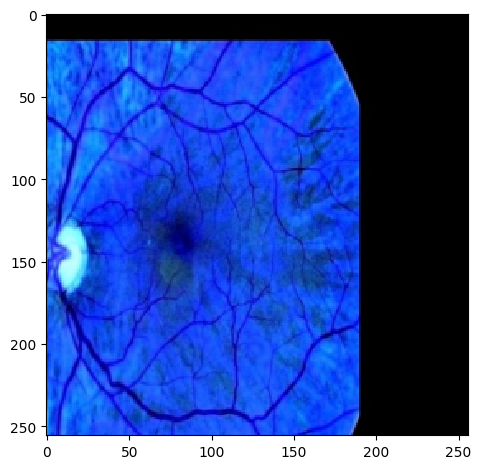

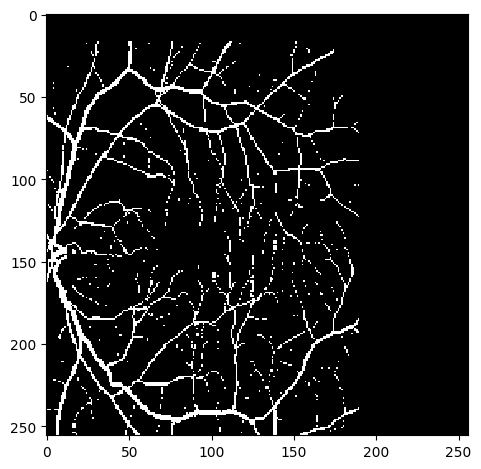

In [8]:
#testing train
img_x=random.randint(0, len(train_ids))
imshow(X_train[img_x])
plt.show()
imshow(Y_train[img_x])
plt.show()

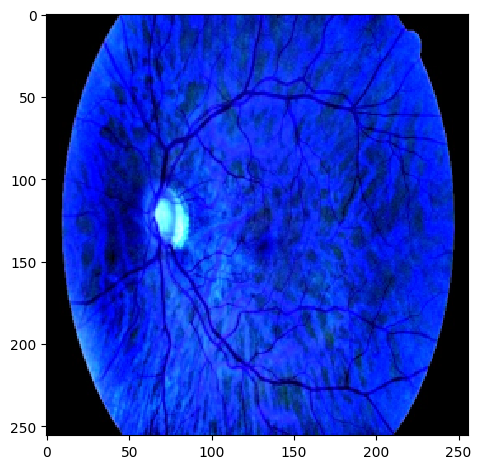

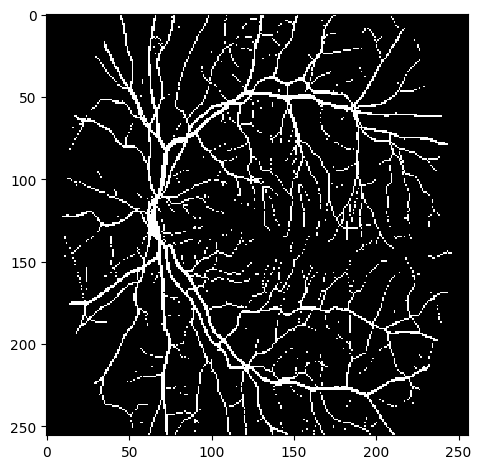

In [9]:
#testing test
img_x=random.randint(0, len(test_ids))
imshow(X_test[img_x])
plt.show()
imshow(Y_test[img_x])
plt.show()

In [8]:
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.metrics import Accuracy, Recall, Precision
from tensorflow.keras.callbacks import ModelCheckpoint, CSVLogger, ReduceLROnPlateau, EarlyStopping, TensorBoard
from Metrics import dice_coef, dice_loss, iou

In [9]:
#Defining parameters
batch_size = 16
lr = 1e-3
num_epochs = 80
model_path = os.path.join('vggpreprocessed.h5')
csv_path = os.path.join('vggpreprocessed.csv')

In [10]:
from tensorflow.keras.layers import Conv2D, BatchNormalization, Activation, MaxPool2D, Conv2DTranspose, Concatenate, Input
from tensorflow.keras.models import Model
from tensorflow.keras.applications import VGG16

In [11]:
def conv_block(input, num_filters):
    x = Conv2D(num_filters, 3, padding="same")(input)
    x = BatchNormalization()(x)
    x = Activation("relu")(x)
 
    x = Conv2D(num_filters, 3, padding="same")(x)
    x = BatchNormalization()(x)
    x = Activation("relu")(x)
 
    return x

In [12]:
def decoder_block(input, skip_features, num_filters):
    x = Conv2DTranspose(num_filters, (2, 2), strides=2, padding="same")(input)
    x = Concatenate()([x, skip_features])
    x = conv_block(x, num_filters)
    return x

In [13]:
def build_vgg16_unet(input_shape):
    inputs = Input(input_shape)
    
    vgg16 = VGG16(include_top=False, weights="imagenet", input_tensor=inputs)
    vgg16.trainable = False
    
    s1 = vgg16.get_layer("block1_conv2").output         ## (512 x 512)
    s2 = vgg16.get_layer("block2_conv2").output         ## (256 x 256)
    s3 = vgg16.get_layer("block3_conv3").output         ## (128 x 128)
    s4 = vgg16.get_layer("block4_conv3").output         ## (64 x 64)

    """ Bridge """ 
    b1 = vgg16.get_layer("block5_conv3").output         ## (32 x 32)

    d1 = decoder_block(b1, s4, 512)                     ## (64 x 64)
    d2 = decoder_block(d1, s3, 256)                     ## (128 x 128)
    d3 = decoder_block(d2, s2, 128)                     ## (256 x 256)
    d4 = decoder_block(d3, s1, 64)                      ## (512 x 512)

    """ Output """
    outputs = Conv2D(1, 1, padding="same", activation="sigmoid")(d4)
    model = Model(inputs, outputs, name="VGG16_U-Net")  
    return model

In [14]:
input_shape = (height, width, 3)
model = build_vgg16_unet(input_shape)
model.compile(optimizer=Adam(lr), loss=dice_loss, metrics=[dice_coef, iou, Accuracy(), Recall(), Precision()])
model.summary()

Model: "VGG16_U-Net"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 256, 256, 3) 0                                            
__________________________________________________________________________________________________
block1_conv1 (Conv2D)           (None, 256, 256, 64) 1792        input_1[0][0]                    
__________________________________________________________________________________________________
block1_conv2 (Conv2D)           (None, 256, 256, 64) 36928       block1_conv1[0][0]               
__________________________________________________________________________________________________
block1_pool (MaxPooling2D)      (None, 128, 128, 64) 0           block1_conv2[0][0]               
________________________________________________________________________________________

In [15]:
#Model Checkpoint
checkpointer=tf.keras.callbacks.ModelCheckpoint('model_for_retina', verbose=1,save_best_only=True)

callbacks=[
    ModelCheckpoint(model_path, verbose=1, save_best_only=True),
    tf.keras.callbacks.EarlyStopping(patience=50, monitor='val_loss'),
    tf.keras.callbacks.TensorBoard(log_dir='logs'),
    CSVLogger(csv_path),
]

results=model.fit(X_train, Y_train, validation_split = 0.1, batch_size = batch_size, epochs = num_epochs, callbacks=callbacks)

Epoch 1/80
  1/395 [..............................] - ETA: 0s - loss: 0.8999 - dice_coef: 0.1001 - iou: 0.0527 - accuracy: 0.0000e+00 - recall: 0.3463 - precision: 0.0407WARNING:tensorflow:From C:\Users\User\.conda\envs\tensorflow\lib\site-packages\tensorflow\python\ops\summary_ops_v2.py:1277: stop (from tensorflow.python.eager.profiler) is deprecated and will be removed after 2020-07-01.
Instructions for updating:
use `tf.profiler.experimental.stop` instead.
395/395 [==============================] - ETA: 0s - loss: 0.2955 - dice_coef: 0.7047 - iou: 0.5523 - accuracy: 0.0254 - recall: 0.7644 - precision: 0.6703
Epoch 00001: val_loss improved from inf to 0.24248, saving model to vggpreprocessed.h5
395/395 [==============================] - 263s 666ms/step - loss: 0.2955 - dice_coef: 0.7047 - iou: 0.5523 - accuracy: 0.0254 - recall: 0.7644 - precision: 0.6703 - val_loss: 0.2425 - val_dice_coef: 0.7576 - val_iou: 0.6099 - val_accuracy: 0.0378 - val_recall: 0.7982 - val_precision: 0.7377


Epoch 15/80
395/395 [==============================] - ETA: 0s - loss: 0.1744 - dice_coef: 0.8256 - iou: 0.7032 - accuracy: 0.0591 - recall: 0.8204 - precision: 0.8316
Epoch 00015: val_loss did not improve from 0.18533
395/395 [==============================] - 251s 636ms/step - loss: 0.1744 - dice_coef: 0.8256 - iou: 0.7032 - accuracy: 0.0591 - recall: 0.8204 - precision: 0.8316 - val_loss: 0.1879 - val_dice_coef: 0.8122 - val_iou: 0.6840 - val_accuracy: 0.0611 - val_recall: 0.8376 - val_precision: 0.7892
Epoch 16/80
395/395 [==============================] - ETA: 0s - loss: 0.1732 - dice_coef: 0.8268 - iou: 0.7048 - accuracy: 0.0594 - recall: 0.8216 - precision: 0.8327
Epoch 00016: val_loss did not improve from 0.18533
395/395 [==============================] - 252s 637ms/step - loss: 0.1732 - dice_coef: 0.8268 - iou: 0.7048 - accuracy: 0.0594 - recall: 0.8216 - precision: 0.8327 - val_loss: 0.1857 - val_dice_coef: 0.8144 - val_iou: 0.6871 - val_accuracy: 0.0608 - val_recall: 0.8319 

395/395 [==============================] - 252s 637ms/step - loss: 0.1603 - dice_coef: 0.8397 - iou: 0.7238 - accuracy: 0.0620 - recall: 0.8329 - precision: 0.8470 - val_loss: 0.1795 - val_dice_coef: 0.8206 - val_iou: 0.6960 - val_accuracy: 0.0615 - val_recall: 0.8255 - val_precision: 0.8161
Epoch 31/80
395/395 [==============================] - ETA: 0s - loss: 0.1597 - dice_coef: 0.8403 - iou: 0.7247 - accuracy: 0.0622 - recall: 0.8335 - precision: 0.8475
Epoch 00031: val_loss did not improve from 0.17843
395/395 [==============================] - 251s 635ms/step - loss: 0.1597 - dice_coef: 0.8403 - iou: 0.7247 - accuracy: 0.0622 - recall: 0.8335 - precision: 0.8475 - val_loss: 0.1790 - val_dice_coef: 0.8211 - val_iou: 0.6967 - val_accuracy: 0.0614 - val_recall: 0.8218 - val_precision: 0.8207
Epoch 32/80
395/395 [==============================] - ETA: 0s - loss: 0.1593 - dice_coef: 0.8407 - iou: 0.7253 - accuracy: 0.0625 - recall: 0.8338 - precision: 0.8481
Epoch 00032: val_loss impro

Epoch 46/80
395/395 [==============================] - ETA: 0s - loss: 0.1515 - dice_coef: 0.8486 - iou: 0.7371 - accuracy: 0.0681 - recall: 0.8406 - precision: 0.8570
Epoch 00046: val_loss improved from 0.17652 to 0.17603, saving model to vggpreprocessed.h5
395/395 [==============================] - 251s 636ms/step - loss: 0.1515 - dice_coef: 0.8486 - iou: 0.7371 - accuracy: 0.0681 - recall: 0.8406 - precision: 0.8570 - val_loss: 0.1760 - val_dice_coef: 0.8241 - val_iou: 0.7010 - val_accuracy: 0.0653 - val_recall: 0.8194 - val_precision: 0.8291
Epoch 47/80
395/395 [==============================] - ETA: 0s - loss: 0.1510 - dice_coef: 0.8489 - iou: 0.7377 - accuracy: 0.0685 - recall: 0.8411 - precision: 0.8575
Epoch 00047: val_loss did not improve from 0.17603
395/395 [==============================] - 252s 639ms/step - loss: 0.1510 - dice_coef: 0.8489 - iou: 0.7377 - accuracy: 0.0685 - recall: 0.8411 - precision: 0.8575 - val_loss: 0.1763 - val_dice_coef: 0.8238 - val_iou: 0.7005 - va

395/395 [==============================] - 252s 638ms/step - loss: 0.1455 - dice_coef: 0.8544 - iou: 0.7459 - accuracy: 0.0796 - recall: 0.8457 - precision: 0.8639 - val_loss: 0.1745 - val_dice_coef: 0.8256 - val_iou: 0.7032 - val_accuracy: 0.0797 - val_recall: 0.8191 - val_precision: 0.8323
Epoch 62/80
395/395 [==============================] - ETA: 0s - loss: 0.1452 - dice_coef: 0.8547 - iou: 0.7464 - accuracy: 0.0822 - recall: 0.8457 - precision: 0.8645
Epoch 00062: val_loss did not improve from 0.17450
395/395 [==============================] - 251s 635ms/step - loss: 0.1452 - dice_coef: 0.8547 - iou: 0.7464 - accuracy: 0.0822 - recall: 0.8457 - precision: 0.8645 - val_loss: 0.1750 - val_dice_coef: 0.8252 - val_iou: 0.7025 - val_accuracy: 0.0792 - val_recall: 0.8134 - val_precision: 0.8374
Epoch 63/80
395/395 [==============================] - ETA: 0s - loss: 0.1444 - dice_coef: 0.8557 - iou: 0.7479 - accuracy: 0.0830 - recall: 0.8465 - precision: 0.8652
Epoch 00063: val_loss did n

Epoch 78/80
395/395 [==============================] - ETA: 0s - loss: 0.1401 - dice_coef: 0.8599 - iou: 0.7544 - accuracy: 0.1025 - recall: 0.8503 - precision: 0.8700
Epoch 00078: val_loss did not improve from 0.17450
395/395 [==============================] - 252s 638ms/step - loss: 0.1401 - dice_coef: 0.8599 - iou: 0.7544 - accuracy: 0.1025 - recall: 0.8503 - precision: 0.8700 - val_loss: 0.1779 - val_dice_coef: 0.8222 - val_iou: 0.6983 - val_accuracy: 0.1003 - val_recall: 0.7895 - val_precision: 0.8580
Epoch 79/80
395/395 [==============================] - ETA: 0s - loss: 0.1399 - dice_coef: 0.8601 - iou: 0.7547 - accuracy: 0.1025 - recall: 0.8504 - precision: 0.8705
Epoch 00079: val_loss improved from 0.17450 to 0.17418, saving model to vggpreprocessed.h5
395/395 [==============================] - 252s 639ms/step - loss: 0.1399 - dice_coef: 0.8601 - iou: 0.7547 - accuracy: 0.1025 - recall: 0.8504 - precision: 0.8705 - val_loss: 0.1742 - val_dice_coef: 0.8259 - val_iou: 0.7037 - va

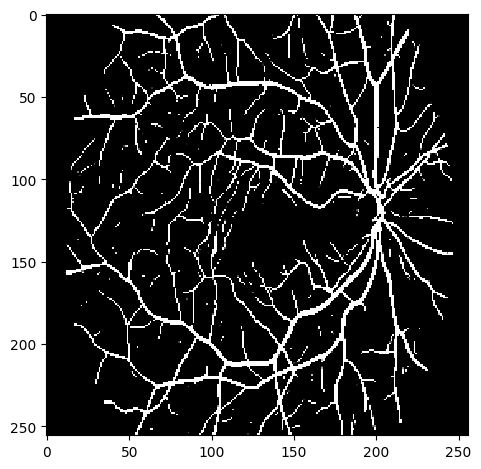

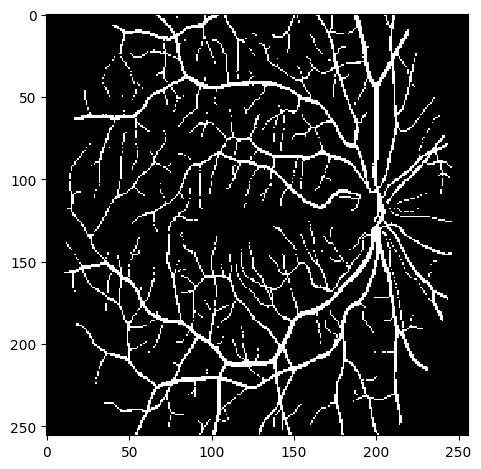

In [16]:
Y_pred = model.predict(X_test)
imshow(Y_pred[11])
plt.show()
imshow(Y_test[11])
plt.show()

In [17]:
results = model.evaluate(X_test, Y_test, verbose=1)
print(results)

1/1 [==============================] - 0s 3ms/step - loss: 0.2192 - dice_coef: 0.7808 - iou: 0.6404 - accuracy: 0.1081 - recall: 0.7544 - precision: 0.8093
[0.21918253600597382, 0.780817449092865, 0.6404436826705933, 0.10813140869140625, 0.7543988823890686, 0.8092902898788452]


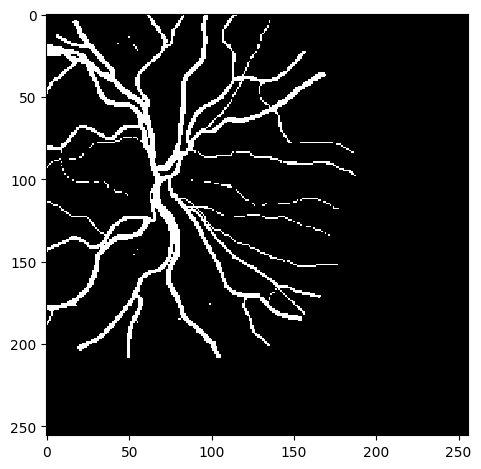

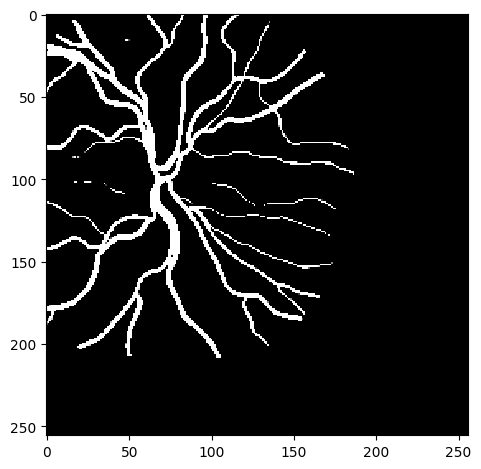

In [12]:
from tensorflow import keras

def get_model(model_name, compile = False):
    return keras.models.load_model(model_name, compile=False)

model = get_model('vggpreprocessed.h5', False)
X = np.zeros((1, width, height, channels))
X[0] = X_train[0]
Y_pred = model.predict(X)
imshow(Y_train[0])
plt.show()
imshow(Y_pred[0])
plt.show()

In [14]:
%load_ext tensorboard
%tensorboard --logdir={'logs'}